In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [11]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None, horizon=8)
df.to_pickle('/tmp/df_horizon8_price_type_none.pkl')
display(df)

op            hi          lo  \
timestamp                 symbol                                           
2019-07-20 12:00:00+00:00 BNB        30.722500     30.772500     30.6250   
                          BTC     10564.250000  10630.000000  10525.5000   
                          ETH       225.930000    226.440000    225.5100   
                          XRP         0.327975      0.328400      0.3270   
2019-07-20 13:00:00+00:00 BNB        30.625000     30.867500     30.3350   
...                                        ...           ...         ...   
2022-11-09 18:00:00+00:00 ETH      1218.600000   1269.900000   1181.2000   
                          LINK        6.549500      6.585000      6.2205   
                          MATIC       0.821400      0.835000      0.7952   
                          SOL        14.862500     15.137500     12.1000   
                          XRP         0.359050      0.360625      0.3435   

                                            cl        volume  \
timestamp                 symbol                               
2019-07-20 12:00:00+00:00 BNB        30.625000  2.215166e+04   
                          BTC     10539.500000  1.052997e+07   
                          ETH       225.830000  0.000000e+00   
                          XRP         0.327975  0.000000e+00   
2019-07-20 13:00:00+00:00 BNB        30.562500  1.649716e+05   
...                                        ...           ...   
2022-11-09 18:00:00+00:00 ETH      1182.500000  1.666431e+08   
                          LINK        6.354000  3.235070e+06   
                          MATIC       0.818200  6.307637e+06   
                          SOL        13.770000  8.465485e+07   
                          XRP         0.350275  3.780293e+06   

                                        execution_start_at       ret  
timestamp                 symbol                                      
2019-07-20 12:00:00+00:00 BNB    2019-07-20 13:00:00+00:00  0.026612  
                          BTC    2019-07-20 13:00:00+00:00  0.034090  
                          ETH    2019-07-20 13:00:00+00:00  0.030901  
                          XRP    2019-07-20 13:00:00+00:00  0.037908  
2019-07-20 13:00:00+00:00 BNB    2019-07-20 14:00:00+00:00  0.026836  
...                                                    ...       ...  
2022-11-09 18:00:00+00:00 ETH    2022-11-09 19:00:00+00:00       NaN  
                          LINK   2022-11-09 19:00:00+00:00       NaN  
                          MATIC  2022-11-09 19:00:00+00:00       NaN  
                          SOL    2022-11-09 19:00:00+00:00       NaN  
                          XRP    2022-11-09 19:00:00+00:00       NaN  

[262098 rows x 7 columns]

In [12]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            # (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['ln_volume'] = np.log1p(df['volume'])

    dfs = [df]
    
    # for i in range(1, 96):
    # for i in range(1, 96 // 4):
    for i in range(1, 96 // 8):
    # for i in range(1, 192 // 8):
        dfs += [
            # (df['ln_cl'] - df['ln_cl'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_cl_kairi'.format(i)), # good
            # df['ln_cl'].diff(8).shift(i * 8).fillna(0).rename('feature_ln_cl_diff_{:02}'.format(i)),
            df['ln_cl'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)), # good
            # df['ln_cl'].diff(1 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].diff(4 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].rolling(8 * i).std().fillna(0).rename('feature_{:02}_ln_cl_std'.format(i)),
            # df['ln_volume'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_volume_diff'.format(i)),
            # df['ln_volume'].rolling(8 * i).mean().fillna(0).rename('feature_{:02}_ln_volume_mean'.format(i)),
            # np.log1p(df['volume'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_volume_mean2'.format(i)),
            # signed_rsi_sma(df['cl'], timeperiod=i).fillna(0).rename('feature_{:02}_rsi'.format(i)),
        ]

    return pd.concat(dfs, axis=1)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda,
    GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

In [14]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [15]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [16]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [17]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [18]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [19]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None
        self.ensemble = ensemble
        self.horizon = 8

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            # patience=10,
            patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    tb, # last
                ],
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 1 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        # sw = np.abs(df['ret'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = np.sign(df['ret'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    act = 'elu' # good for cnn?
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    # act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    # bias_initializer = 'he_normal'
    
#     def initializer(shape, dtype=None):
#         p = 0.1
#         dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
#         # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
#         # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
#         # w = w ** 3 # 3 is good
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         print(shape)
#         n_in, n_out = shape
#         # w /= n_in ** 0.5
#         # w /= n_out ** 0.5 # good
        
#         # https://arxiv.org/pdf/1902.06853.pdf
#         w /= n_in ** 0.5
#         # w *= 1.3
#         # w *= 0.9
#         return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    size = 32
    # size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    def conv1d_mean_zero(x):
        return x - tf.math.reduce_mean(x, axis=-1, keepdims=True)
    
    # x = Reshape((23, 2))(x)
    # x = Reshape((11, 4))(x)
    # x = Reshape((95, 2))(x)
    x = Reshape((11, 2))(x)
    # x = Reshape((11, 3))(x)
    # def f1(x):
    #     x = tf.math.cumsum(x, axis=-2)
    #     # x -= tf.math.reduce_mean(x, axis=-2, keepdims=True)
    #     return x
    # x = Lambda(f1)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32, 
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero, # good?
    )(x)
    # x = MaxPooling1D(2)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32,
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero,
    )(x)
    # x = Dropout(0.5)(x)
    # x = Conv1D(
    #     filters=32, 
    #     kernel_size=4,
    #     activation=act, use_bias=True, 
    #     # padding='SAME',
    #     padding='VALID',
    #     kernel_regularizer=reg, 
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, 
    #     # bias_initializer=initializer,
    # )(x)
    # x = Dropout(0.5)(x)
    x = MaxPooling1D(2)(x) # good?
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = GlobalMaxPooling1D()(x)
    # x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    
#     depth = 2 + idx * 0
#     for i in range(depth):
#         t = 1.0 * i / (depth - 1)
#         x_prev = x
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         mars_constraint = MarsConstraint(8)
#         mars_constraints.append(mars_constraint)
#         # dense = GaussianDropConnectDense(
#         dense = Dense(
#             # size,
#             # 32,
#             # 64,
#             128, # good with l2 reg
#             # 256,
#             # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             # 64 if i == 0 else 128,
#             activation=act, 
#             # activation=None,
#             use_bias=True,
#             # use_bias=False,
#             # kernel_regularizer=reg_l1, 
#             kernel_regularizer=reg,
#             # kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             bias_initializer=bias_initializer,
#             # kernel_constraint=mars_constraint,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense)
#         # dense = GaussianDropConnect(dense, rate=0.2)
#         x = dense(x)
#         # x = BatchNormalization()(x)
#         # def smooth_units(x):
#         #     return (x[:, 1:] + x[:, :-1]) / 2
#         #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
#         # x = Lambda(smooth_units)(x)
#         # x = Activation(act)(x)
#         # x = Lambda(smooth_units)(x)
#         # if i > 0:
#         #     x = Add()([x, x_prev])
#         # if i == 9:
#         #     x = tf.keras.layers.GaussianDropout(0.5)(x)
#         # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
#         # x = Dropout(dropout_rate)(x)
#         # x = Dropout(0.1)(x)
#         # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
#         hidden_outputs.append(x)

        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1,
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    opt = Nadam(
        # learning_rate=0.002 * 1e-1,
        learning_rate=0.002,
        beta_1=0.9, 
        # beta_1=0.5,
        # beta_2=0.9,
        beta_2=0.999,
        epsilon=None,
        # epsilon=1e-1,
        # epsilon=1e-3,
        schedule_decay=0.004,
    )
    # opt = tfa.optimizers.AdaBelief(
    #     # learning_rate=0.001,
    #     learning_rate=0.001 / 8,
    #     # learning_rate=0.001 / 8 / 8,
    #     # learning_rate=0.001 / 8 / 8 / 8,
    #     # total_steps=1200,
    #     # warmup_proportion=0.1,
    #     # min_lr=1e-5,
    #     # rectify=True,
    #     # weight_decay=1e-2,
    #     # weight_decay=1e-3,
    #     # epsilon=1e-10,
    # )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     learning_rate=0.002,
    #     # learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

float32
fit df.shape (201190, 39)


2022-11-09 20:03:16.586788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-09 20:03:16.587355: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-09 20:03:16.587394: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8d0215ec498b): /proc/driver/nvidia/version does not exist
2022-11-09 20:03:16.588101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: /tmp/tmp4vhl76dy/assets


INFO:tensorflow:Assets written to: /tmp/tmp4vhl76dy/assets
2022-11-09 20:09:12.847582: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:12.847665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:12.848411: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4vhl76dy
2022-11-09 20:09:12.850901: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:12.850958: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4vhl76dy
2022-11-09 20:09:12.859427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-09 20:09:12.862059: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:12.923648: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpftqnuj8h/assets


INFO:tensorflow:Assets written to: /tmp/tmpftqnuj8h/assets
2022-11-09 20:09:14.859773: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:14.859851: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:14.860040: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpftqnuj8h
2022-11-09 20:09:14.862156: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:14.862196: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpftqnuj8h
2022-11-09 20:09:14.870312: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:14.927139: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpftqnuj8h
2022-11-09 20:09:14.941998: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm93wgdfl/assets


INFO:tensorflow:Assets written to: /tmp/tmpm93wgdfl/assets
2022-11-09 20:09:16.608780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:16.608853: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:16.609032: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm93wgdfl
2022-11-09 20:09:16.611074: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:16.611117: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm93wgdfl
2022-11-09 20:09:16.618884: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:16.671955: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm93wgdfl
2022-11-09 20:09:16.685982: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzi0_vfc7/assets


INFO:tensorflow:Assets written to: /tmp/tmpzi0_vfc7/assets
2022-11-09 20:09:18.290444: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:18.290516: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:18.290740: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzi0_vfc7
2022-11-09 20:09:18.292675: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:18.292713: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzi0_vfc7
2022-11-09 20:09:18.300132: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:18.360437: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzi0_vfc7
2022-11-09 20:09:18.373862: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcpwob1rg/assets


INFO:tensorflow:Assets written to: /tmp/tmpcpwob1rg/assets
2022-11-09 20:09:19.888895: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:19.888963: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:19.889131: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcpwob1rg
2022-11-09 20:09:19.891035: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:19.891070: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcpwob1rg
2022-11-09 20:09:19.898605: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:19.948734: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcpwob1rg
2022-11-09 20:09:19.962170: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpztm9v6v1/assets


INFO:tensorflow:Assets written to: /tmp/tmpztm9v6v1/assets
2022-11-09 20:09:21.400278: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:21.400347: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:21.400568: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpztm9v6v1
2022-11-09 20:09:21.402376: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:21.402411: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpztm9v6v1
2022-11-09 20:09:21.409721: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:21.459336: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpztm9v6v1
2022-11-09 20:09:21.471933: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnmc7b6_v/assets


INFO:tensorflow:Assets written to: /tmp/tmpnmc7b6_v/assets
2022-11-09 20:09:23.570005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:23.570074: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:23.570229: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnmc7b6_v
2022-11-09 20:09:23.572027: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:23.572062: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnmc7b6_v
2022-11-09 20:09:23.577594: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:23.626442: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnmc7b6_v
2022-11-09 20:09:23.639385: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfyxx1acm/assets


INFO:tensorflow:Assets written to: /tmp/tmpfyxx1acm/assets
2022-11-09 20:09:24.966611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:24.966711: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:24.966863: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfyxx1acm
2022-11-09 20:09:24.968417: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:24.968448: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfyxx1acm
2022-11-09 20:09:24.973677: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:25.018528: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfyxx1acm
2022-11-09 20:09:25.030381: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphjywmscp/assets


INFO:tensorflow:Assets written to: /tmp/tmphjywmscp/assets
2022-11-09 20:09:26.358881: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:26.358946: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:26.359100: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphjywmscp
2022-11-09 20:09:26.360724: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:26.360756: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphjywmscp
2022-11-09 20:09:26.365644: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:26.408676: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphjywmscp
2022-11-09 20:09:26.420610: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk81_41cc/assets


INFO:tensorflow:Assets written to: /tmp/tmpk81_41cc/assets
2022-11-09 20:09:27.695665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:09:27.695723: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:09:27.695873: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk81_41cc
2022-11-09 20:09:27.697544: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:09:27.697578: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk81_41cc
2022-11-09 20:09:27.702538: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:09:27.747491: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk81_41cc
2022-11-09 20:09:27.759283: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

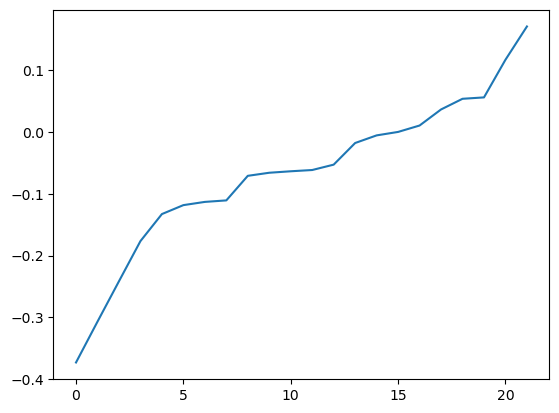

fit df.shape (186931, 39)


INFO:tensorflow:Assets written to: /tmp/tmp3fd7sohj/assets


INFO:tensorflow:Assets written to: /tmp/tmp3fd7sohj/assets
2022-11-09 20:18:08.575384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:08.575467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:08.575673: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3fd7sohj
2022-11-09 20:18:08.577885: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:08.577929: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3fd7sohj
2022-11-09 20:18:08.584903: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:08.646507: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3fd7sohj
2022-11-09 20:18:08.662876: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_q6uly_6/assets


INFO:tensorflow:Assets written to: /tmp/tmp_q6uly_6/assets
2022-11-09 20:18:10.468856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:10.468930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:10.469127: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_q6uly_6
2022-11-09 20:18:10.471248: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:10.471291: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_q6uly_6
2022-11-09 20:18:10.478382: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:10.539018: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_q6uly_6
2022-11-09 20:18:10.555627: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1b9hh7is/assets


INFO:tensorflow:Assets written to: /tmp/tmp1b9hh7is/assets
2022-11-09 20:18:12.377744: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:12.377817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:12.378013: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1b9hh7is
2022-11-09 20:18:12.380172: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:12.380214: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1b9hh7is
2022-11-09 20:18:12.387254: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:12.453174: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1b9hh7is
2022-11-09 20:18:12.470449: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplpjjayw9/assets


INFO:tensorflow:Assets written to: /tmp/tmplpjjayw9/assets
2022-11-09 20:18:14.190954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:14.191029: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:14.191214: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplpjjayw9
2022-11-09 20:18:14.193149: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:14.193186: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplpjjayw9
2022-11-09 20:18:14.199370: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:14.254418: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplpjjayw9
2022-11-09 20:18:14.268923: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyv1vq5pe/assets


INFO:tensorflow:Assets written to: /tmp/tmpyv1vq5pe/assets
2022-11-09 20:18:15.857958: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:15.858030: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:15.858207: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyv1vq5pe
2022-11-09 20:18:15.860095: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:15.860132: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyv1vq5pe
2022-11-09 20:18:15.866056: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:15.919355: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyv1vq5pe
2022-11-09 20:18:15.933186: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0g97bjge/assets


INFO:tensorflow:Assets written to: /tmp/tmp0g97bjge/assets
2022-11-09 20:18:17.506503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:17.506610: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:17.506783: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0g97bjge
2022-11-09 20:18:17.508535: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:17.508571: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0g97bjge
2022-11-09 20:18:17.514273: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:17.564395: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0g97bjge
2022-11-09 20:18:17.578046: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd5van9uz/assets


INFO:tensorflow:Assets written to: /tmp/tmpd5van9uz/assets
2022-11-09 20:18:19.068349: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:19.068418: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:19.068640: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd5van9uz
2022-11-09 20:18:19.070333: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:19.070367: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd5van9uz
2022-11-09 20:18:19.075918: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:19.125402: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd5van9uz
2022-11-09 20:18:19.138414: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcrlbhr5w/assets


INFO:tensorflow:Assets written to: /tmp/tmpcrlbhr5w/assets
2022-11-09 20:18:20.574062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:20.574131: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:20.574296: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcrlbhr5w
2022-11-09 20:18:20.576146: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:20.576181: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcrlbhr5w
2022-11-09 20:18:20.583185: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:20.631912: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcrlbhr5w
2022-11-09 20:18:20.644733: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5lp6xkfo/assets


INFO:tensorflow:Assets written to: /tmp/tmp5lp6xkfo/assets
2022-11-09 20:18:22.108251: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:22.108318: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:22.108477: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5lp6xkfo
2022-11-09 20:18:22.110256: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:22.110289: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5lp6xkfo
2022-11-09 20:18:22.117152: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:22.164014: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5lp6xkfo
2022-11-09 20:18:22.176606: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfq1x3k5j/assets


INFO:tensorflow:Assets written to: /tmp/tmpfq1x3k5j/assets
2022-11-09 20:18:24.507725: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:18:24.507789: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:18:24.507997: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfq1x3k5j
2022-11-09 20:18:24.509707: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:18:24.509738: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfq1x3k5j
2022-11-09 20:18:24.515247: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:18:24.564958: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfq1x3k5j
2022-11-09 20:18:24.577595: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

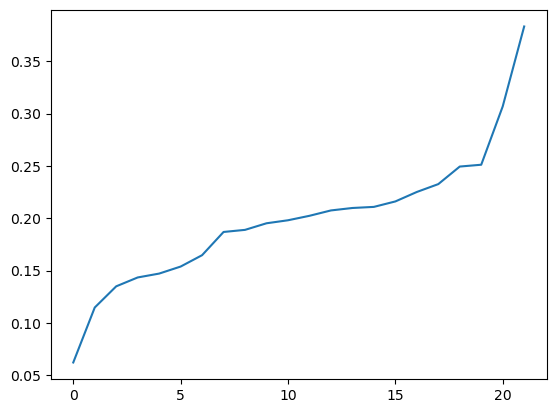

fit df.shape (179957, 39)


INFO:tensorflow:Assets written to: /tmp/tmpdjpk_jh3/assets


INFO:tensorflow:Assets written to: /tmp/tmpdjpk_jh3/assets
2022-11-09 20:28:40.803813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:40.803959: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:40.804174: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdjpk_jh3
2022-11-09 20:28:40.806408: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:40.806454: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdjpk_jh3
2022-11-09 20:28:40.814312: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:40.879129: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdjpk_jh3
2022-11-09 20:28:40.896166: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfnvw9x4c/assets


INFO:tensorflow:Assets written to: /tmp/tmpfnvw9x4c/assets
2022-11-09 20:28:42.812132: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:42.812271: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:42.812481: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfnvw9x4c
2022-11-09 20:28:42.814642: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:42.814686: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfnvw9x4c
2022-11-09 20:28:42.821969: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:42.884109: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfnvw9x4c
2022-11-09 20:28:42.900270: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp24t_w8mc/assets


INFO:tensorflow:Assets written to: /tmp/tmp24t_w8mc/assets
2022-11-09 20:28:44.691183: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:44.691312: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:44.691514: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp24t_w8mc
2022-11-09 20:28:44.693623: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:44.693664: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp24t_w8mc
2022-11-09 20:28:44.700718: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:44.763312: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp24t_w8mc
2022-11-09 20:28:44.779581: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpextmhf15/assets


INFO:tensorflow:Assets written to: /tmp/tmpextmhf15/assets
2022-11-09 20:28:46.617308: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:46.617382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:46.617570: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpextmhf15
2022-11-09 20:28:46.619583: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:46.619624: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpextmhf15
2022-11-09 20:28:46.626319: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:46.684376: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpextmhf15
2022-11-09 20:28:46.699366: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjojccggl/assets


INFO:tensorflow:Assets written to: /tmp/tmpjojccggl/assets
2022-11-09 20:28:48.354148: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:48.354223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:48.354457: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjojccggl
2022-11-09 20:28:48.356291: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:48.356328: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjojccggl
2022-11-09 20:28:48.362473: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:48.416410: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjojccggl
2022-11-09 20:28:48.430628: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo084pwzz/assets


INFO:tensorflow:Assets written to: /tmp/tmpo084pwzz/assets
2022-11-09 20:28:50.023756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:50.023833: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:50.024017: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo084pwzz
2022-11-09 20:28:50.025890: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:50.025929: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo084pwzz
2022-11-09 20:28:50.032107: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:50.085469: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo084pwzz
2022-11-09 20:28:50.100300: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcomdw6o6/assets


INFO:tensorflow:Assets written to: /tmp/tmpcomdw6o6/assets
2022-11-09 20:28:51.663921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:51.663994: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:51.664216: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcomdw6o6
2022-11-09 20:28:51.665980: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:51.666016: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcomdw6o6
2022-11-09 20:28:51.671869: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:51.723022: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcomdw6o6
2022-11-09 20:28:51.736645: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxqa78pv7/assets


INFO:tensorflow:Assets written to: /tmp/tmpxqa78pv7/assets
2022-11-09 20:28:53.262749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:53.262822: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:53.263000: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxqa78pv7
2022-11-09 20:28:53.264786: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:53.264821: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxqa78pv7
2022-11-09 20:28:53.270726: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:53.322535: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxqa78pv7
2022-11-09 20:28:53.336776: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxpdhx9_d/assets


INFO:tensorflow:Assets written to: /tmp/tmpxpdhx9_d/assets
2022-11-09 20:28:54.910639: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:54.910708: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:54.910868: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxpdhx9_d
2022-11-09 20:28:54.912631: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:54.912664: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxpdhx9_d
2022-11-09 20:28:54.918208: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:54.966130: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxpdhx9_d
2022-11-09 20:28:54.979223: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqnun5kpx/assets


INFO:tensorflow:Assets written to: /tmp/tmpqnun5kpx/assets
2022-11-09 20:28:56.435412: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:28:56.435483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:28:56.435649: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqnun5kpx
2022-11-09 20:28:56.437338: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:28:56.437418: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqnun5kpx
2022-11-09 20:28:56.442997: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:28:56.501433: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqnun5kpx
2022-11-09 20:28:56.515852: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

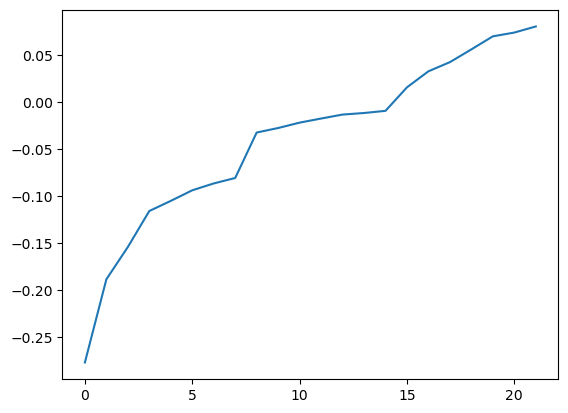

fit df.shape (179957, 39)


INFO:tensorflow:Assets written to: /tmp/tmp0bg_pllk/assets


INFO:tensorflow:Assets written to: /tmp/tmp0bg_pllk/assets
2022-11-09 20:37:55.352336: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:37:55.352427: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:37:55.352748: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0bg_pllk
2022-11-09 20:37:55.355131: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:37:55.355182: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0bg_pllk
2022-11-09 20:37:55.363190: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:37:55.432818: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0bg_pllk
2022-11-09 20:37:55.451562: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb_s8judj/assets


INFO:tensorflow:Assets written to: /tmp/tmpb_s8judj/assets
2022-11-09 20:37:57.567354: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:37:57.567475: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:37:57.567802: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb_s8judj
2022-11-09 20:37:57.570168: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:37:57.570217: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb_s8judj
2022-11-09 20:37:57.578949: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:37:57.652347: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb_s8judj
2022-11-09 20:37:57.670564: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzpjywun9/assets


INFO:tensorflow:Assets written to: /tmp/tmpzpjywun9/assets
2022-11-09 20:37:59.717392: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:37:59.717480: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:37:59.717772: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzpjywun9
2022-11-09 20:37:59.720082: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:37:59.720129: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzpjywun9
2022-11-09 20:37:59.728094: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:37:59.796697: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzpjywun9
2022-11-09 20:37:59.814658: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbcxtcr34/assets


INFO:tensorflow:Assets written to: /tmp/tmpbcxtcr34/assets
2022-11-09 20:38:01.796274: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:38:01.796359: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:38:01.796621: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbcxtcr34
2022-11-09 20:38:01.798867: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:38:01.798909: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbcxtcr34
2022-11-09 20:38:01.806068: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:38:01.870450: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbcxtcr34
2022-11-09 20:38:01.889444: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1yv_y2tz/assets


INFO:tensorflow:Assets written to: /tmp/tmp1yv_y2tz/assets
2022-11-09 20:38:03.827524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:38:03.827665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:38:03.827882: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1yv_y2tz
2022-11-09 20:38:03.829987: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:38:03.830028: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1yv_y2tz
2022-11-09 20:38:03.836865: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:38:03.895757: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1yv_y2tz
2022-11-09 20:38:03.911552: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpso6pfqq1/assets


INFO:tensorflow:Assets written to: /tmp/tmpso6pfqq1/assets
2022-11-09 20:38:05.713275: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:38:05.713355: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:38:05.713550: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpso6pfqq1
2022-11-09 20:38:05.715630: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:38:05.715671: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpso6pfqq1
2022-11-09 20:38:05.722590: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:38:05.781950: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpso6pfqq1
2022-11-09 20:38:05.799213: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9_mr8b0p/assets


INFO:tensorflow:Assets written to: /tmp/tmp9_mr8b0p/assets
2022-11-09 20:38:07.539996: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:38:07.540070: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:38:07.540254: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9_mr8b0p
2022-11-09 20:38:07.542206: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:38:07.542245: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9_mr8b0p
2022-11-09 20:38:07.549386: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:38:07.605631: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9_mr8b0p
2022-11-09 20:38:07.620031: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqgrgcb2z/assets


INFO:tensorflow:Assets written to: /tmp/tmpqgrgcb2z/assets
2022-11-09 20:38:09.255225: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:38:09.255303: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:38:09.255479: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqgrgcb2z
2022-11-09 20:38:09.257368: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:38:09.257405: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqgrgcb2z
2022-11-09 20:38:09.263729: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:38:09.318375: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqgrgcb2z
2022-11-09 20:38:09.332754: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppjd4pj_u/assets


INFO:tensorflow:Assets written to: /tmp/tmppjd4pj_u/assets
2022-11-09 20:38:10.929939: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:38:10.930013: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:38:10.930193: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppjd4pj_u
2022-11-09 20:38:10.932102: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:38:10.932140: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppjd4pj_u
2022-11-09 20:38:10.938532: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:38:10.993936: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppjd4pj_u
2022-11-09 20:38:11.008437: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0dqgdzdd/assets


INFO:tensorflow:Assets written to: /tmp/tmp0dqgdzdd/assets
2022-11-09 20:38:12.642410: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:38:12.642484: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:38:12.642713: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0dqgdzdd
2022-11-09 20:38:12.644517: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:38:12.644654: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0dqgdzdd
2022-11-09 20:38:12.650829: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:38:12.703815: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0dqgdzdd
2022-11-09 20:38:12.718206: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

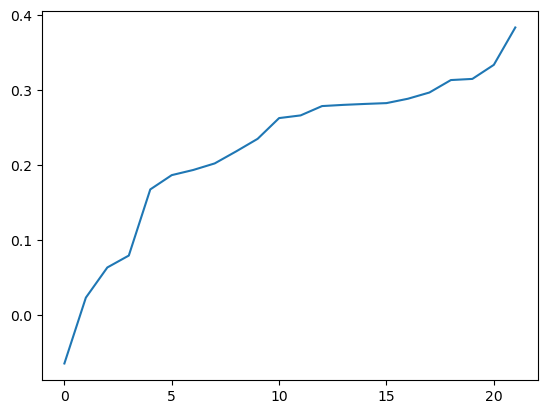

fit df.shape (180191, 39)


INFO:tensorflow:Assets written to: /tmp/tmpzjqejg14/assets


INFO:tensorflow:Assets written to: /tmp/tmpzjqejg14/assets
2022-11-09 20:57:57.963141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:57:57.963229: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:57:57.963507: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzjqejg14
2022-11-09 20:57:57.965753: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:57:57.965798: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzjqejg14
2022-11-09 20:57:57.973151: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:57:58.037585: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzjqejg14
2022-11-09 20:57:58.054424: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp81wmqm_f/assets


INFO:tensorflow:Assets written to: /tmp/tmp81wmqm_f/assets
2022-11-09 20:57:59.980720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:57:59.980806: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:57:59.981014: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp81wmqm_f
2022-11-09 20:57:59.983284: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:57:59.983327: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp81wmqm_f
2022-11-09 20:57:59.990495: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:58:00.054732: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp81wmqm_f
2022-11-09 20:58:00.071620: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe05woqe_/assets


INFO:tensorflow:Assets written to: /tmp/tmpe05woqe_/assets
2022-11-09 20:58:01.877111: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:58:01.877189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:58:01.877440: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe05woqe_
2022-11-09 20:58:01.879515: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:58:01.879557: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe05woqe_
2022-11-09 20:58:01.886056: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:58:01.944729: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe05woqe_
2022-11-09 20:58:01.961061: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgf12a2zp/assets


INFO:tensorflow:Assets written to: /tmp/tmpgf12a2zp/assets
2022-11-09 20:58:03.696096: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:58:03.696172: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:58:03.696414: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgf12a2zp
2022-11-09 20:58:03.698447: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:58:03.698489: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgf12a2zp
2022-11-09 20:58:03.704874: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:58:03.765263: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgf12a2zp
2022-11-09 20:58:03.780386: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpufgxvntz/assets


INFO:tensorflow:Assets written to: /tmp/tmpufgxvntz/assets
2022-11-09 20:58:05.468111: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:58:05.468190: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:58:05.468429: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpufgxvntz
2022-11-09 20:58:05.470314: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:58:05.470352: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpufgxvntz
2022-11-09 20:58:05.476468: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:58:05.532192: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpufgxvntz
2022-11-09 20:58:05.547583: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa8m0tiak/assets


INFO:tensorflow:Assets written to: /tmp/tmpa8m0tiak/assets
2022-11-09 20:58:07.161920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:58:07.161994: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:58:07.162175: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa8m0tiak
2022-11-09 20:58:07.164030: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:58:07.164066: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa8m0tiak
2022-11-09 20:58:07.170250: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:58:07.224866: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa8m0tiak
2022-11-09 20:58:07.239497: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7x5v1cnx/assets


INFO:tensorflow:Assets written to: /tmp/tmp7x5v1cnx/assets
2022-11-09 20:58:08.920138: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:58:08.920216: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:58:08.920440: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7x5v1cnx
2022-11-09 20:58:08.922291: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:58:08.922327: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7x5v1cnx
2022-11-09 20:58:08.929897: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:58:08.989125: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7x5v1cnx
2022-11-09 20:58:09.004138: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3i_r5ayh/assets


INFO:tensorflow:Assets written to: /tmp/tmp3i_r5ayh/assets
2022-11-09 20:58:10.550460: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:58:10.550535: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:58:10.550758: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3i_r5ayh
2022-11-09 20:58:10.552616: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:58:10.552653: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3i_r5ayh
2022-11-09 20:58:10.558675: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:58:10.610545: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3i_r5ayh
2022-11-09 20:58:10.624063: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuwtjp6dz/assets


INFO:tensorflow:Assets written to: /tmp/tmpuwtjp6dz/assets
2022-11-09 20:58:12.174723: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:58:12.174791: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:58:12.174957: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuwtjp6dz
2022-11-09 20:58:12.176742: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:58:12.176770: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuwtjp6dz
2022-11-09 20:58:12.182456: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:58:12.231998: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuwtjp6dz
2022-11-09 20:58:12.248036: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5d6gd2me/assets


INFO:tensorflow:Assets written to: /tmp/tmp5d6gd2me/assets
2022-11-09 20:58:13.735840: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 20:58:13.735916: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 20:58:13.736086: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5d6gd2me
2022-11-09 20:58:13.737837: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 20:58:13.737873: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5d6gd2me
2022-11-09 20:58:13.743830: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 20:58:13.792894: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5d6gd2me
2022-11-09 20:58:13.805580: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

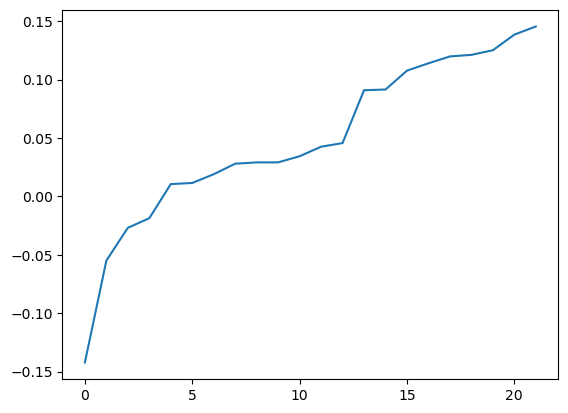

return without cost statistics
mean 0.0015680641146053266
std 0.009783020128881026
sharpe 0.16028425720766462
double sharpe 1.9777980882842152
max drawdown 0.20619499179236012
return with cost statistics
mean 0.00034655411972235427
std 0.009803198768715694
sharpe 0.03535112649437342
double sharpe 0.19554476998874695
max drawdown 0.2066413928874925


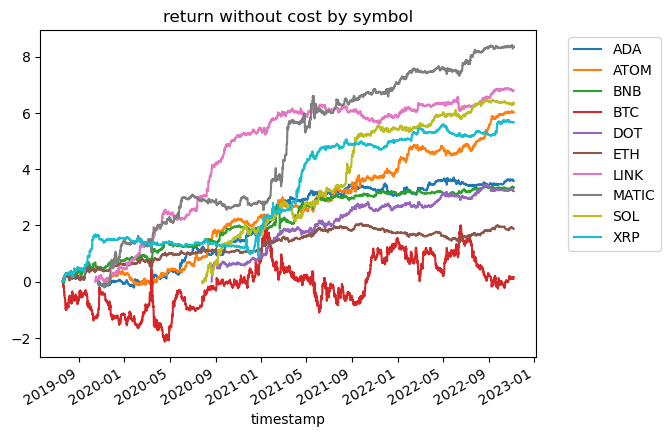

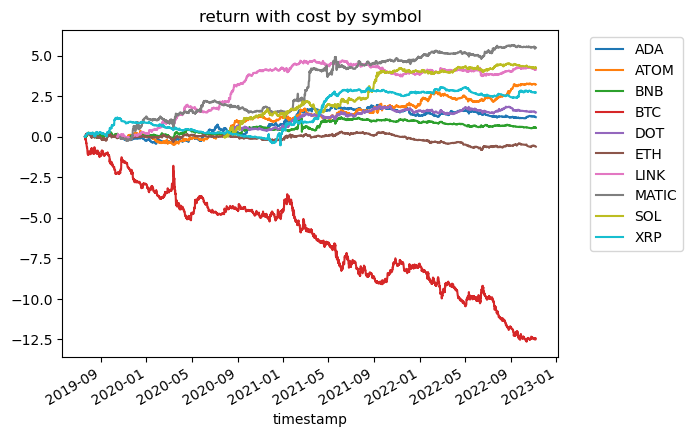

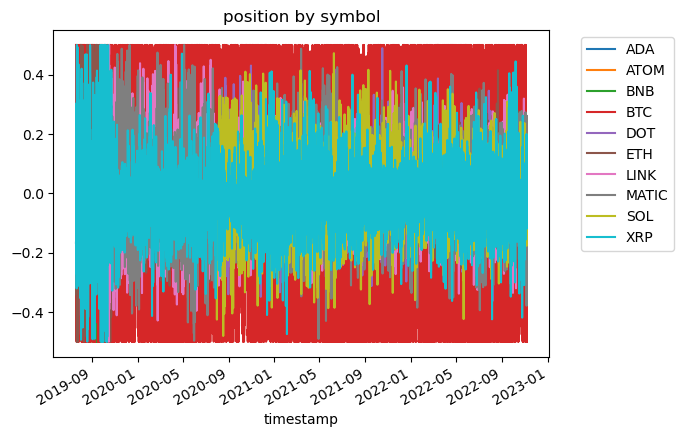

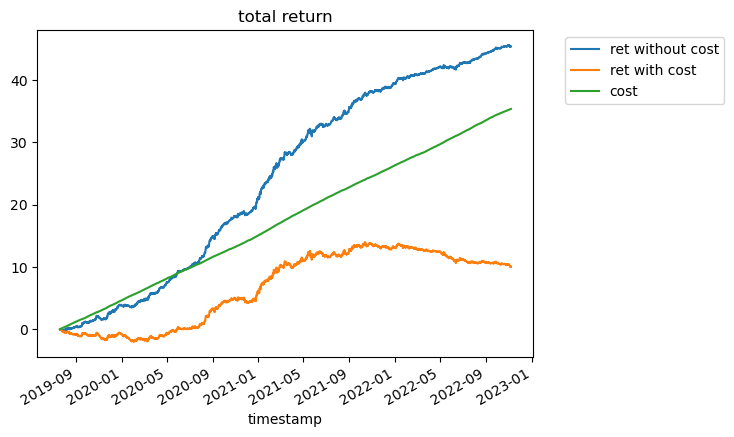

fit df.shape (232490, 39)


INFO:tensorflow:Assets written to: /tmp/tmp1o6cpic1/assets


INFO:tensorflow:Assets written to: /tmp/tmp1o6cpic1/assets
2022-11-09 22:27:52.172959: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:27:52.173043: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:27:52.173244: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1o6cpic1
2022-11-09 22:27:52.175391: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:27:52.175434: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1o6cpic1
2022-11-09 22:27:52.182407: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:27:52.244194: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1o6cpic1
2022-11-09 22:27:52.260996: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3jfkkygq/assets


INFO:tensorflow:Assets written to: /tmp/tmp3jfkkygq/assets
2022-11-09 22:27:54.094274: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:27:54.094351: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:27:54.094549: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3jfkkygq
2022-11-09 22:27:54.096682: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:27:54.096722: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3jfkkygq
2022-11-09 22:27:54.103584: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:27:54.164966: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3jfkkygq
2022-11-09 22:27:54.181616: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgo8fyteh/assets


INFO:tensorflow:Assets written to: /tmp/tmpgo8fyteh/assets
2022-11-09 22:27:55.928289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:27:55.928363: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:27:55.928547: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgo8fyteh
2022-11-09 22:27:55.930542: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:27:55.930580: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgo8fyteh
2022-11-09 22:27:55.936976: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:27:55.993598: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgo8fyteh
2022-11-09 22:27:56.008695: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpl50wce0w/assets


INFO:tensorflow:Assets written to: /tmp/tmpl50wce0w/assets
2022-11-09 22:27:57.687681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:27:57.687756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:27:57.687939: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpl50wce0w
2022-11-09 22:27:57.689865: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:27:57.689903: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpl50wce0w
2022-11-09 22:27:57.696107: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:27:57.749713: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpl50wce0w
2022-11-09 22:27:57.763627: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjnov_q_o/assets


INFO:tensorflow:Assets written to: /tmp/tmpjnov_q_o/assets
2022-11-09 22:27:59.329624: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:27:59.329695: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:27:59.329853: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjnov_q_o
2022-11-09 22:27:59.331681: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:27:59.331708: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjnov_q_o
2022-11-09 22:27:59.337519: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:27:59.389341: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjnov_q_o
2022-11-09 22:27:59.403459: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkoeq9rr6/assets


INFO:tensorflow:Assets written to: /tmp/tmpkoeq9rr6/assets
2022-11-09 22:28:00.927882: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:00.927949: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:00.928167: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkoeq9rr6
2022-11-09 22:28:00.929934: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:00.929965: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkoeq9rr6
2022-11-09 22:28:00.935584: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:00.985908: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkoeq9rr6
2022-11-09 22:28:00.999222: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd4fwa6gz/assets


INFO:tensorflow:Assets written to: /tmp/tmpd4fwa6gz/assets
2022-11-09 22:28:02.458470: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:02.458537: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:02.458704: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd4fwa6gz
2022-11-09 22:28:02.460505: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:02.460543: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd4fwa6gz
2022-11-09 22:28:02.466158: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:02.514938: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd4fwa6gz
2022-11-09 22:28:02.527955: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3mtve3jm/assets


INFO:tensorflow:Assets written to: /tmp/tmp3mtve3jm/assets
2022-11-09 22:28:03.960445: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:03.960514: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:03.960677: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3mtve3jm
2022-11-09 22:28:03.962388: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:03.962421: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3mtve3jm
2022-11-09 22:28:03.967984: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:04.021677: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3mtve3jm
2022-11-09 22:28:04.035607: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpno4o4xhh/assets


INFO:tensorflow:Assets written to: /tmp/tmpno4o4xhh/assets
2022-11-09 22:28:05.532684: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:05.532749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:05.532958: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpno4o4xhh
2022-11-09 22:28:05.534758: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:05.534791: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpno4o4xhh
2022-11-09 22:28:05.542010: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:05.590702: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpno4o4xhh
2022-11-09 22:28:05.603368: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdzwwhyt7/assets


INFO:tensorflow:Assets written to: /tmp/tmpdzwwhyt7/assets
2022-11-09 22:28:06.955372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:06.955439: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:06.955643: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdzwwhyt7
2022-11-09 22:28:06.957370: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:06.957404: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdzwwhyt7
2022-11-09 22:28:06.964364: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:07.011783: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdzwwhyt7
2022-11-09 22:28:07.024467: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplak1k09t/assets


INFO:tensorflow:Assets written to: /tmp/tmplak1k09t/assets
2022-11-09 22:28:09.964655: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:09.964721: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:09.964891: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplak1k09t
2022-11-09 22:28:09.969337: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:09.969364: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplak1k09t
2022-11-09 22:28:09.989766: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:10.104744: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplak1k09t
2022-11-09 22:28:10.141197: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppgx2ostx/assets


INFO:tensorflow:Assets written to: /tmp/tmppgx2ostx/assets
2022-11-09 22:28:11.831280: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:11.831350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:11.831528: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppgx2ostx
2022-11-09 22:28:11.835071: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:11.835112: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppgx2ostx
2022-11-09 22:28:11.844764: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:11.905996: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppgx2ostx
2022-11-09 22:28:11.923442: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp02zekyxk/assets


INFO:tensorflow:Assets written to: /tmp/tmp02zekyxk/assets
2022-11-09 22:28:13.293192: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:13.293256: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:13.293408: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp02zekyxk
2022-11-09 22:28:13.295175: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:13.295209: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp02zekyxk
2022-11-09 22:28:13.300982: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:13.348364: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp02zekyxk
2022-11-09 22:28:13.361287: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqi6uhw7u/assets


INFO:tensorflow:Assets written to: /tmp/tmpqi6uhw7u/assets
2022-11-09 22:28:14.680096: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:14.680157: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:14.680351: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqi6uhw7u
2022-11-09 22:28:14.681933: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:14.681963: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqi6uhw7u
2022-11-09 22:28:14.687319: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:14.733932: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqi6uhw7u
2022-11-09 22:28:14.746266: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbyvsjyam/assets


INFO:tensorflow:Assets written to: /tmp/tmpbyvsjyam/assets
2022-11-09 22:28:16.062211: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:16.062274: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:16.062466: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbyvsjyam
2022-11-09 22:28:16.064029: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:16.064060: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbyvsjyam
2022-11-09 22:28:16.069259: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:16.113854: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbyvsjyam
2022-11-09 22:28:16.126052: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphnra5ibj/assets


INFO:tensorflow:Assets written to: /tmp/tmphnra5ibj/assets
2022-11-09 22:28:17.419433: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:17.419492: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:17.419638: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphnra5ibj
2022-11-09 22:28:17.421177: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:17.421209: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphnra5ibj
2022-11-09 22:28:17.429321: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:17.475309: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphnra5ibj
2022-11-09 22:28:17.489962: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpckiwojgz/assets


INFO:tensorflow:Assets written to: /tmp/tmpckiwojgz/assets
2022-11-09 22:28:18.785981: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:18.786040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:18.786186: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpckiwojgz
2022-11-09 22:28:18.787763: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:18.787794: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpckiwojgz
2022-11-09 22:28:18.792974: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:18.836966: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpckiwojgz
2022-11-09 22:28:18.848386: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfw9_mnqa/assets


INFO:tensorflow:Assets written to: /tmp/tmpfw9_mnqa/assets
2022-11-09 22:28:20.145274: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:20.145338: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:20.145520: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfw9_mnqa
2022-11-09 22:28:20.147095: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:20.147126: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfw9_mnqa
2022-11-09 22:28:20.152410: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:20.196375: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfw9_mnqa
2022-11-09 22:28:20.208017: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp05_tugpl/assets


INFO:tensorflow:Assets written to: /tmp/tmp05_tugpl/assets
2022-11-09 22:28:21.535261: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:21.535311: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:21.535463: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp05_tugpl
2022-11-09 22:28:21.537011: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:21.537038: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp05_tugpl
2022-11-09 22:28:21.542143: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:21.585398: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp05_tugpl
2022-11-09 22:28:21.597060: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_ekl9zd9/assets


INFO:tensorflow:Assets written to: /tmp/tmp_ekl9zd9/assets
2022-11-09 22:28:22.890724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:22.890789: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:22.890942: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_ekl9zd9
2022-11-09 22:28:22.892462: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:22.892493: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_ekl9zd9
2022-11-09 22:28:22.897527: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:22.941447: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_ekl9zd9
2022-11-09 22:28:22.952681: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4v9won26/assets


INFO:tensorflow:Assets written to: /tmp/tmp4v9won26/assets
2022-11-09 22:28:24.244732: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:24.244799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:24.244949: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4v9won26
2022-11-09 22:28:24.246486: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:24.246517: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4v9won26
2022-11-09 22:28:24.251490: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:24.294824: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4v9won26
2022-11-09 22:28:24.306443: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1oigbbnp/assets


INFO:tensorflow:Assets written to: /tmp/tmp1oigbbnp/assets
2022-11-09 22:28:25.588317: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:25.588376: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:25.588529: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1oigbbnp
2022-11-09 22:28:25.590131: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:25.590163: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1oigbbnp
2022-11-09 22:28:25.595290: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:25.638912: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1oigbbnp
2022-11-09 22:28:25.650694: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1qiwsm29/assets


INFO:tensorflow:Assets written to: /tmp/tmp1qiwsm29/assets
2022-11-09 22:28:26.941049: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:26.941108: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:26.941302: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1qiwsm29
2022-11-09 22:28:26.942856: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:26.942889: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1qiwsm29
2022-11-09 22:28:26.947902: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:26.991454: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1qiwsm29
2022-11-09 22:28:27.002694: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpi3a3eutv/assets


INFO:tensorflow:Assets written to: /tmp/tmpi3a3eutv/assets
2022-11-09 22:28:28.291739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:28.291800: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:28.291951: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi3a3eutv
2022-11-09 22:28:28.293480: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:28.293513: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi3a3eutv
2022-11-09 22:28:28.298543: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:28.342700: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi3a3eutv
2022-11-09 22:28:28.354476: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptl1_l3bs/assets


INFO:tensorflow:Assets written to: /tmp/tmptl1_l3bs/assets
2022-11-09 22:28:29.636559: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:29.636617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:29.636770: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptl1_l3bs
2022-11-09 22:28:29.638379: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:29.638413: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptl1_l3bs
2022-11-09 22:28:29.643464: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:29.686871: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptl1_l3bs
2022-11-09 22:28:29.698167: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuptumwue/assets


INFO:tensorflow:Assets written to: /tmp/tmpuptumwue/assets
2022-11-09 22:28:33.109183: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:33.109248: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:33.109457: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuptumwue
2022-11-09 22:28:33.112411: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:33.112448: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuptumwue
2022-11-09 22:28:33.123753: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:33.188216: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuptumwue
2022-11-09 22:28:33.206408: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpalh4sxzn/assets


INFO:tensorflow:Assets written to: /tmp/tmpalh4sxzn/assets
2022-11-09 22:28:34.505998: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:34.506055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:34.506188: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpalh4sxzn
2022-11-09 22:28:34.507916: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:34.507946: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpalh4sxzn
2022-11-09 22:28:34.514064: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:34.560010: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpalh4sxzn
2022-11-09 22:28:34.572826: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpehpui7yo/assets


INFO:tensorflow:Assets written to: /tmp/tmpehpui7yo/assets
2022-11-09 22:28:35.784128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:35.784187: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:35.784325: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpehpui7yo
2022-11-09 22:28:35.785900: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:35.785924: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpehpui7yo
2022-11-09 22:28:35.791382: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:35.836962: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpehpui7yo
2022-11-09 22:28:35.848084: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzji4oi29/assets


INFO:tensorflow:Assets written to: /tmp/tmpzji4oi29/assets
2022-11-09 22:28:36.999473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:36.999526: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:36.999727: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzji4oi29
2022-11-09 22:28:37.001022: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:37.001050: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzji4oi29
2022-11-09 22:28:37.005829: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:37.055476: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzji4oi29
2022-11-09 22:28:37.067939: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt60lidqa/assets


INFO:tensorflow:Assets written to: /tmp/tmpt60lidqa/assets
2022-11-09 22:28:38.254162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:38.254213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:38.254336: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt60lidqa
2022-11-09 22:28:38.255592: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:38.255618: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt60lidqa
2022-11-09 22:28:38.260318: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:38.301761: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt60lidqa
2022-11-09 22:28:38.312502: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjq6ws6sv/assets


INFO:tensorflow:Assets written to: /tmp/tmpjq6ws6sv/assets
2022-11-09 22:28:39.480819: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:39.480873: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:39.481001: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjq6ws6sv
2022-11-09 22:28:39.482283: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:39.482309: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjq6ws6sv
2022-11-09 22:28:39.486879: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:39.526103: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjq6ws6sv
2022-11-09 22:28:39.539700: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsdvb7gs4/assets


INFO:tensorflow:Assets written to: /tmp/tmpsdvb7gs4/assets
2022-11-09 22:28:40.832654: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:40.832709: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:40.832930: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsdvb7gs4
2022-11-09 22:28:40.834275: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:40.834301: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsdvb7gs4
2022-11-09 22:28:40.838650: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:40.876882: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsdvb7gs4
2022-11-09 22:28:40.886897: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2az_0cep/assets


INFO:tensorflow:Assets written to: /tmp/tmp2az_0cep/assets
2022-11-09 22:28:42.050363: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:42.050459: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:42.050870: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2az_0cep
2022-11-09 22:28:42.052625: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:42.052656: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2az_0cep
2022-11-09 22:28:42.058067: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:42.098024: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2az_0cep
2022-11-09 22:28:42.109046: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfgigc5uh/assets


INFO:tensorflow:Assets written to: /tmp/tmpfgigc5uh/assets
2022-11-09 22:28:43.279825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:43.279953: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:43.280124: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfgigc5uh
2022-11-09 22:28:43.281562: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:43.281588: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfgigc5uh
2022-11-09 22:28:43.286022: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:43.323500: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfgigc5uh
2022-11-09 22:28:43.333624: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcx99wzrt/assets


INFO:tensorflow:Assets written to: /tmp/tmpcx99wzrt/assets
2022-11-09 22:28:44.482425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:44.482478: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:44.482637: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcx99wzrt
2022-11-09 22:28:44.484022: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:44.484047: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcx99wzrt
2022-11-09 22:28:44.488299: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:44.526489: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcx99wzrt
2022-11-09 22:28:44.539309: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx2ok1ffi/assets


INFO:tensorflow:Assets written to: /tmp/tmpx2ok1ffi/assets
2022-11-09 22:28:45.717175: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:45.717226: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:45.717353: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx2ok1ffi
2022-11-09 22:28:45.718615: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:45.718640: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx2ok1ffi
2022-11-09 22:28:45.723882: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:45.761685: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx2ok1ffi
2022-11-09 22:28:45.771763: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7mpn9q77/assets


INFO:tensorflow:Assets written to: /tmp/tmp7mpn9q77/assets
2022-11-09 22:28:48.595389: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:48.595455: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:48.595629: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7mpn9q77
2022-11-09 22:28:48.599158: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:48.599192: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7mpn9q77
2022-11-09 22:28:48.614113: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:48.705434: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7mpn9q77
2022-11-09 22:28:48.732913: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfiahufaz/assets


INFO:tensorflow:Assets written to: /tmp/tmpfiahufaz/assets
2022-11-09 22:28:50.307599: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:50.307664: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:50.307839: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfiahufaz
2022-11-09 22:28:50.310510: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:50.310547: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfiahufaz
2022-11-09 22:28:50.318892: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:50.375247: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfiahufaz
2022-11-09 22:28:50.390968: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvwg6v9o9/assets


INFO:tensorflow:Assets written to: /tmp/tmpvwg6v9o9/assets
2022-11-09 22:28:51.688968: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:51.689031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:51.689177: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvwg6v9o9
2022-11-09 22:28:51.690885: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:51.690954: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvwg6v9o9
2022-11-09 22:28:51.696876: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:51.743149: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvwg6v9o9
2022-11-09 22:28:51.754912: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb016glhd/assets


INFO:tensorflow:Assets written to: /tmp/tmpb016glhd/assets
2022-11-09 22:28:52.993625: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:52.993674: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:52.993815: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb016glhd
2022-11-09 22:28:52.995329: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:52.995359: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb016glhd
2022-11-09 22:28:53.001184: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:53.042486: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb016glhd
2022-11-09 22:28:53.053793: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2hu6i339/assets


INFO:tensorflow:Assets written to: /tmp/tmp2hu6i339/assets
2022-11-09 22:28:54.226829: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:54.226908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:54.227039: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2hu6i339
2022-11-09 22:28:54.228382: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:54.228409: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2hu6i339
2022-11-09 22:28:54.232997: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:54.274856: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2hu6i339
2022-11-09 22:28:54.285472: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnu8unno6/assets


INFO:tensorflow:Assets written to: /tmp/tmpnu8unno6/assets
2022-11-09 22:28:55.477144: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:55.477197: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:55.477362: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnu8unno6
2022-11-09 22:28:55.478810: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:55.478837: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnu8unno6
2022-11-09 22:28:55.483826: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:55.532295: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnu8unno6
2022-11-09 22:28:55.543723: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpap_ng1_7/assets


INFO:tensorflow:Assets written to: /tmp/tmpap_ng1_7/assets
2022-11-09 22:28:56.730413: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:56.730466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:56.730657: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpap_ng1_7
2022-11-09 22:28:56.732088: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:56.732114: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpap_ng1_7
2022-11-09 22:28:56.736781: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:56.777242: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpap_ng1_7
2022-11-09 22:28:56.787827: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpis30h2nv/assets


INFO:tensorflow:Assets written to: /tmp/tmpis30h2nv/assets
2022-11-09 22:28:58.025108: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:58.025161: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:58.025422: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpis30h2nv
2022-11-09 22:28:58.027018: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:58.027045: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpis30h2nv
2022-11-09 22:28:58.032410: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:58.085204: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpis30h2nv
2022-11-09 22:28:58.099161: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbh7afr80/assets


INFO:tensorflow:Assets written to: /tmp/tmpbh7afr80/assets
2022-11-09 22:28:59.259691: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:28:59.259746: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:28:59.259877: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbh7afr80
2022-11-09 22:28:59.261205: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:28:59.261232: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbh7afr80
2022-11-09 22:28:59.265844: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:28:59.305450: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbh7afr80
2022-11-09 22:28:59.315815: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_x56ks26/assets


INFO:tensorflow:Assets written to: /tmp/tmp_x56ks26/assets
2022-11-09 22:29:00.542263: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:00.542327: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:00.542469: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_x56ks26
2022-11-09 22:29:00.543944: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:00.544022: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_x56ks26
2022-11-09 22:29:00.549329: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:00.595718: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_x56ks26
2022-11-09 22:29:00.606173: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpshcxjjq6/assets


INFO:tensorflow:Assets written to: /tmp/tmpshcxjjq6/assets
2022-11-09 22:29:03.299244: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:03.299309: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:03.299481: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpshcxjjq6
2022-11-09 22:29:03.304149: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:03.304184: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpshcxjjq6
2022-11-09 22:29:03.324053: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:03.464894: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpshcxjjq6
2022-11-09 22:29:03.503032: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_u5v0oss/assets


INFO:tensorflow:Assets written to: /tmp/tmp_u5v0oss/assets
2022-11-09 22:29:05.208512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:05.208574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:05.208790: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_u5v0oss
2022-11-09 22:29:05.212107: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:05.212142: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_u5v0oss
2022-11-09 22:29:05.224969: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:05.298924: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_u5v0oss
2022-11-09 22:29:05.319113: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0wsa29qn/assets


INFO:tensorflow:Assets written to: /tmp/tmp0wsa29qn/assets
2022-11-09 22:29:06.627837: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:06.627895: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:06.628072: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0wsa29qn
2022-11-09 22:29:06.629708: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:06.629738: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0wsa29qn
2022-11-09 22:29:06.635924: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:06.682952: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0wsa29qn
2022-11-09 22:29:06.695511: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo835bggh/assets


INFO:tensorflow:Assets written to: /tmp/tmpo835bggh/assets
2022-11-09 22:29:07.901314: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:07.901370: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:07.901502: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo835bggh
2022-11-09 22:29:07.902975: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:07.903003: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo835bggh
2022-11-09 22:29:07.908627: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:07.955524: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo835bggh
2022-11-09 22:29:07.966527: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8heq4uq9/assets


INFO:tensorflow:Assets written to: /tmp/tmp8heq4uq9/assets
2022-11-09 22:29:09.173803: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:09.173858: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:09.173987: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8heq4uq9
2022-11-09 22:29:09.175310: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:09.175411: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8heq4uq9
2022-11-09 22:29:09.180685: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:09.227632: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8heq4uq9
2022-11-09 22:29:09.239612: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5im3wzb1/assets


INFO:tensorflow:Assets written to: /tmp/tmp5im3wzb1/assets
2022-11-09 22:29:10.439169: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:10.439225: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:10.439470: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5im3wzb1
2022-11-09 22:29:10.440812: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:10.440836: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5im3wzb1
2022-11-09 22:29:10.445866: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:10.487508: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5im3wzb1
2022-11-09 22:29:10.498287: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx4c5xe0b/assets


INFO:tensorflow:Assets written to: /tmp/tmpx4c5xe0b/assets
2022-11-09 22:29:11.714128: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:11.714182: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:11.714344: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx4c5xe0b
2022-11-09 22:29:11.715676: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:11.715703: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx4c5xe0b
2022-11-09 22:29:11.720484: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:11.760125: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx4c5xe0b
2022-11-09 22:29:11.770430: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf3qukxpj/assets


INFO:tensorflow:Assets written to: /tmp/tmpf3qukxpj/assets
2022-11-09 22:29:12.942141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:12.942192: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:12.942389: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf3qukxpj
2022-11-09 22:29:12.943750: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:12.943776: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf3qukxpj
2022-11-09 22:29:12.948215: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:12.990943: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf3qukxpj
2022-11-09 22:29:13.002179: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5m01hnf7/assets


INFO:tensorflow:Assets written to: /tmp/tmp5m01hnf7/assets
2022-11-09 22:29:14.171673: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:14.171728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:14.171927: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5m01hnf7
2022-11-09 22:29:14.173179: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:14.173205: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5m01hnf7
2022-11-09 22:29:14.178117: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:14.219131: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5m01hnf7
2022-11-09 22:29:14.229433: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5zj2ls5r/assets


INFO:tensorflow:Assets written to: /tmp/tmp5zj2ls5r/assets
2022-11-09 22:29:15.445636: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:15.445686: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:15.445843: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5zj2ls5r
2022-11-09 22:29:15.447127: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:15.447154: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5zj2ls5r
2022-11-09 22:29:15.451520: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:15.490899: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5zj2ls5r
2022-11-09 22:29:15.501177: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgxvp_gqc/assets


INFO:tensorflow:Assets written to: /tmp/tmpgxvp_gqc/assets
2022-11-09 22:29:18.441668: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:18.441735: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:18.441900: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgxvp_gqc
2022-11-09 22:29:18.445147: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:18.445183: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgxvp_gqc
2022-11-09 22:29:18.457817: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:18.542278: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgxvp_gqc
2022-11-09 22:29:18.567702: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmputa829j8/assets


INFO:tensorflow:Assets written to: /tmp/tmputa829j8/assets
2022-11-09 22:29:20.092117: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:20.092180: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:20.092336: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmputa829j8
2022-11-09 22:29:20.094528: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:20.094561: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmputa829j8
2022-11-09 22:29:20.101734: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:20.152354: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmputa829j8
2022-11-09 22:29:20.166098: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp720q03i/assets


INFO:tensorflow:Assets written to: /tmp/tmpp720q03i/assets
2022-11-09 22:29:21.457449: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:21.457512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:21.457663: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp720q03i
2022-11-09 22:29:21.459462: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:21.459495: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp720q03i
2022-11-09 22:29:21.465468: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:21.513241: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp720q03i
2022-11-09 22:29:21.524610: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpi5ynrnec/assets


INFO:tensorflow:Assets written to: /tmp/tmpi5ynrnec/assets
2022-11-09 22:29:22.719417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:22.719469: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:22.719598: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi5ynrnec
2022-11-09 22:29:22.721003: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:22.721031: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi5ynrnec
2022-11-09 22:29:22.725983: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:22.768219: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi5ynrnec
2022-11-09 22:29:22.780168: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0i_2jpnn/assets


INFO:tensorflow:Assets written to: /tmp/tmp0i_2jpnn/assets
2022-11-09 22:29:23.957556: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:23.957609: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:23.957736: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0i_2jpnn
2022-11-09 22:29:23.959115: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:23.959144: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0i_2jpnn
2022-11-09 22:29:23.964245: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:24.007889: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0i_2jpnn
2022-11-09 22:29:24.019399: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg5xtu_g9/assets


INFO:tensorflow:Assets written to: /tmp/tmpg5xtu_g9/assets
2022-11-09 22:29:25.249013: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:25.249073: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:25.249214: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg5xtu_g9
2022-11-09 22:29:25.250848: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:25.250879: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg5xtu_g9
2022-11-09 22:29:25.255747: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:25.297960: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg5xtu_g9
2022-11-09 22:29:25.309149: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzg2dzlen/assets


INFO:tensorflow:Assets written to: /tmp/tmpzg2dzlen/assets
2022-11-09 22:29:26.490602: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:26.490657: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:26.490806: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzg2dzlen
2022-11-09 22:29:26.492510: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:26.492538: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzg2dzlen
2022-11-09 22:29:26.497378: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:26.540902: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzg2dzlen
2022-11-09 22:29:26.552487: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7beez9d2/assets


INFO:tensorflow:Assets written to: /tmp/tmp7beez9d2/assets
2022-11-09 22:29:29.185929: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:29.185997: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:29.186198: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7beez9d2
2022-11-09 22:29:29.189880: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:29.189916: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7beez9d2
2022-11-09 22:29:29.204617: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:29.289631: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7beez9d2
2022-11-09 22:29:29.316235: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0t6brmam/assets


INFO:tensorflow:Assets written to: /tmp/tmp0t6brmam/assets
2022-11-09 22:29:30.885044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:30.885117: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:30.885296: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0t6brmam
2022-11-09 22:29:30.888919: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:30.888962: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0t6brmam
2022-11-09 22:29:30.899318: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:30.960121: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0t6brmam
2022-11-09 22:29:30.975575: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzaz2bij7/assets


INFO:tensorflow:Assets written to: /tmp/tmpzaz2bij7/assets
2022-11-09 22:29:32.234777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:32.234832: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:32.234963: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzaz2bij7
2022-11-09 22:29:32.236392: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:32.236420: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzaz2bij7
2022-11-09 22:29:32.242033: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:32.286289: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzaz2bij7
2022-11-09 22:29:32.298097: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk2oh0omq/assets


INFO:tensorflow:Assets written to: /tmp/tmpk2oh0omq/assets
2022-11-09 22:29:33.540229: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:33.540333: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:33.540462: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk2oh0omq
2022-11-09 22:29:33.541938: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:33.541967: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk2oh0omq
2022-11-09 22:29:33.547417: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:33.600503: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk2oh0omq
2022-11-09 22:29:33.613142: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4jhoy_4z/assets


INFO:tensorflow:Assets written to: /tmp/tmp4jhoy_4z/assets
2022-11-09 22:29:34.810847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:34.810903: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:34.811070: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4jhoy_4z
2022-11-09 22:29:34.812457: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:34.812525: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4jhoy_4z
2022-11-09 22:29:34.817382: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:34.858055: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4jhoy_4z
2022-11-09 22:29:34.868684: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3g9gj1he/assets


INFO:tensorflow:Assets written to: /tmp/tmp3g9gj1he/assets
2022-11-09 22:29:36.081174: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:36.081232: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:36.081364: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3g9gj1he
2022-11-09 22:29:36.082840: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:36.082870: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3g9gj1he
2022-11-09 22:29:36.088467: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:36.097695: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3g9gj1he
2022-11-09 22:29:36.109011: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpthekpych/assets


INFO:tensorflow:Assets written to: /tmp/tmpthekpych/assets
2022-11-09 22:29:37.294019: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:37.294110: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:37.294290: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpthekpych
2022-11-09 22:29:37.295876: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:37.295903: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpthekpych
2022-11-09 22:29:37.301171: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:37.342676: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpthekpych
2022-11-09 22:29:37.355403: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4ttgfqsv/assets


INFO:tensorflow:Assets written to: /tmp/tmp4ttgfqsv/assets
2022-11-09 22:29:40.018218: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:40.018284: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:40.018450: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4ttgfqsv
2022-11-09 22:29:40.022072: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:40.022109: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4ttgfqsv
2022-11-09 22:29:40.037028: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:40.122593: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4ttgfqsv
2022-11-09 22:29:40.148589: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptrg40sx8/assets


INFO:tensorflow:Assets written to: /tmp/tmptrg40sx8/assets
2022-11-09 22:29:41.749262: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:41.749327: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:41.749532: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptrg40sx8
2022-11-09 22:29:41.752163: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:41.752195: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptrg40sx8
2022-11-09 22:29:41.760894: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:41.817945: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptrg40sx8
2022-11-09 22:29:41.832853: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4n33amo0/assets


INFO:tensorflow:Assets written to: /tmp/tmp4n33amo0/assets
2022-11-09 22:29:43.088715: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:43.088779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:43.088934: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4n33amo0
2022-11-09 22:29:43.090810: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:43.090843: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4n33amo0
2022-11-09 22:29:43.097208: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:43.143123: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4n33amo0
2022-11-09 22:29:43.154930: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn8x9ghk_/assets


INFO:tensorflow:Assets written to: /tmp/tmpn8x9ghk_/assets
2022-11-09 22:29:44.351253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:44.351306: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:44.351469: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn8x9ghk_
2022-11-09 22:29:44.352876: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:44.352903: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn8x9ghk_
2022-11-09 22:29:44.359323: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:44.407626: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn8x9ghk_
2022-11-09 22:29:44.418552: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdvhigtuk/assets


INFO:tensorflow:Assets written to: /tmp/tmpdvhigtuk/assets
2022-11-09 22:29:45.643408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:45.643466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:45.643685: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdvhigtuk
2022-11-09 22:29:45.645201: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:45.645230: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdvhigtuk
2022-11-09 22:29:45.650763: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:45.696855: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdvhigtuk
2022-11-09 22:29:45.707230: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp38ryxg16/assets


INFO:tensorflow:Assets written to: /tmp/tmp38ryxg16/assets
2022-11-09 22:29:47.850590: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:47.850693: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:47.850863: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp38ryxg16
2022-11-09 22:29:47.855724: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:47.855760: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp38ryxg16
2022-11-09 22:29:47.876824: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:48.008318: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp38ryxg16
2022-11-09 22:29:48.047929: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1opgd3df/assets


INFO:tensorflow:Assets written to: /tmp/tmp1opgd3df/assets
2022-11-09 22:29:49.844499: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:49.844564: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:49.844730: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1opgd3df
2022-11-09 22:29:49.848073: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:49.848109: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1opgd3df
2022-11-09 22:29:49.862074: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:49.949436: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1opgd3df
2022-11-09 22:29:49.975190: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpl8ezevps/assets


INFO:tensorflow:Assets written to: /tmp/tmpl8ezevps/assets
2022-11-09 22:29:51.471005: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:51.471067: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:51.471235: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpl8ezevps
2022-11-09 22:29:51.473881: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:51.473917: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpl8ezevps
2022-11-09 22:29:51.482073: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:51.536204: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpl8ezevps
2022-11-09 22:29:51.551601: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp88hp2bl8/assets


INFO:tensorflow:Assets written to: /tmp/tmp88hp2bl8/assets
2022-11-09 22:29:52.819282: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:52.819341: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:52.819597: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp88hp2bl8
2022-11-09 22:29:52.821273: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:52.821305: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp88hp2bl8
2022-11-09 22:29:52.827635: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:52.879967: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp88hp2bl8
2022-11-09 22:29:52.894883: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmzmya1sd/assets


INFO:tensorflow:Assets written to: /tmp/tmpmzmya1sd/assets
2022-11-09 22:29:54.086789: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-09 22:29:54.086844: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-09 22:29:54.087010: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmzmya1sd
2022-11-09 22:29:54.088400: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-09 22:29:54.088428: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmzmya1sd
2022-11-09 22:29:54.093464: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-09 22:29:54.141588: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmzmya1sd
2022-11-09 22:29:54.154965: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [20]:
print(tf.keras.backend.floatx())

# df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = pd.read_pickle('/tmp/df_horizon8_price_type_none.pkl')
# df = pd.read_pickle('/tmp/df_horizon4_price_type_none.pkl')
# df = df.iloc[-10000:]

df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-07 00:00:00Z')]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
# sol_timestamps = df.loc[df.index.get_level_values('symbol') == 'SOL'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]
# df = df.loc[df.index.get_level_values('timestamp').isin(sol_timestamps)]

# model = ExampleModelRank(1)
model = ExampleModelRank(10)

# # cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
# small ensemble result: https://gist.github.com/richmanbtc/5275f155527ae6d7d2232c3aa6d203e9

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221028_btc_one_cnn_h8.xz', 'wb') as f:
    f.write(data)

expt

- [20221028_btc_one_cnn_h8/20221109_222521.ipynb](20221028_btc_one_cnn_h8/20221109_222521.ipynb) without hedge (baseline)
- [20221028_btc_one_cnn_h8/20221109_222624.ipynb](20221028_btc_one_cnn_h8/20221109_222624.ipynb) with hedge

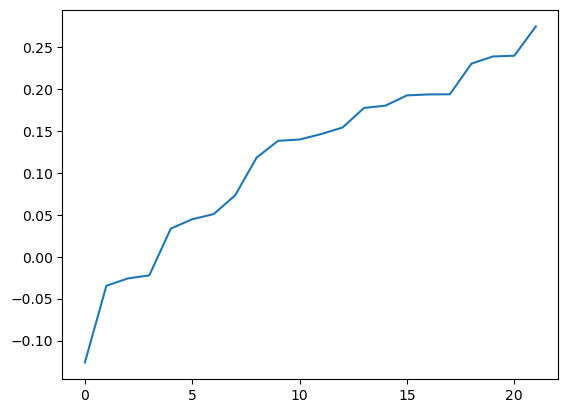

timestamp                  symbol
2022-09-10 18:00:00+00:00  ADA      -0.055556
                           ATOM     -0.055556
                           BNB      -0.055556
                           BTC       0.500000
                           DOT      -0.055556
                                       ...   
2022-11-09 18:00:00+00:00  ETH       0.048524
                           LINK      0.050118
                           MATIC     0.114517
                           SOL       0.132058
                           XRP       0.065368
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


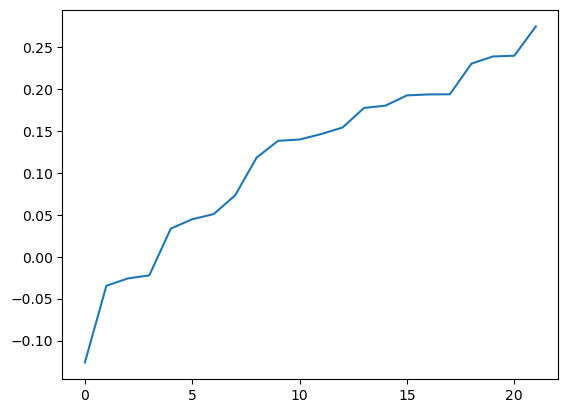

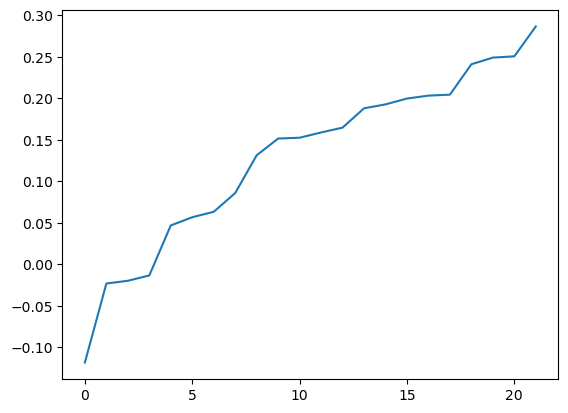

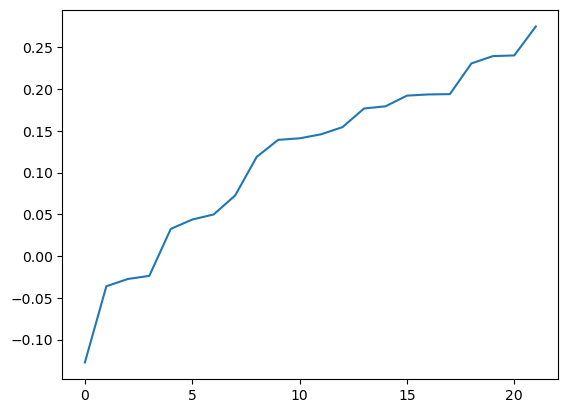

position1  position2  position3
timestamp                 symbol                                 
2022-09-10 19:00:00+00:00 ADA     -0.055556  -0.055556  -0.055556
                          ATOM    -0.055556  -0.055556  -0.055556
                          BNB     -0.055556  -0.055556  -0.055556
                          BTC      0.500000   0.500000   0.500000
                          DOT     -0.055556  -0.055556  -0.055556
...                                     ...        ...        ...
2022-11-09 17:00:00+00:00 ETH      0.063191   0.063191   0.063191
                          LINK     0.045993   0.045993   0.045993
                          MATIC    0.083845   0.083845   0.083845
                          SOL      0.103734   0.103734   0.103734
                          XRP      0.073131   0.073131   0.073131

[14390 rows x 3 columns]

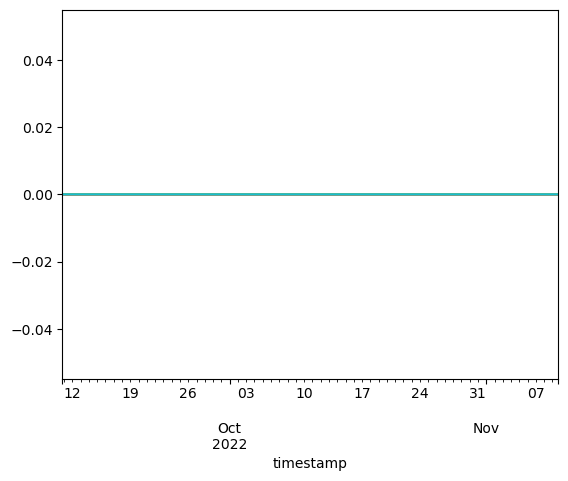

ADA (1439, 4)
ATOM (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
SOL (1439, 4)
XRP (1439, 4)


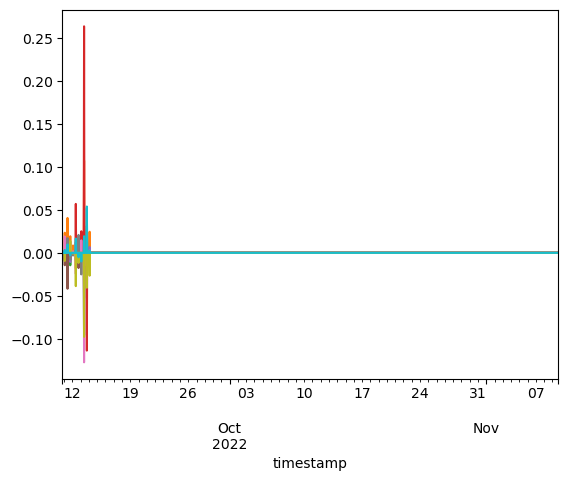

In [21]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20221028_btc_one_cnn_h8.xz')
df = pd.read_pickle('/tmp/df_horizon8_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()